In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

In [2]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [3]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
rcParams['figure.figsize'] = 6,4

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [4]:
# Set directories
path = "../data/"
dir_load = path+"stoch/save/"
dir_load2 = path+"stoch2/save/"
dir_data = path+"compare/"
dir_save = dir_data+"save/"
dir_pic = dir_data+"pic/"

# chech directories exit, create if not
check_dir_exist(dir_save)
check_dir_exist(dir_pic)
check_dir_exist(dir_pic+"svg/")

# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

colormap1 = [sns.color_palette("Paired")[1],
             sns.color_palette("muted")[1],
             sns.color_palette("colorblind")[2],
             sns.color_palette("muted")[0]]

colormap2 = [sns.color_palette("Paired")[9],
             sns.color_palette("colorblind")[8],
             sns.color_palette("colorblind")[9],
             sns.color_palette("muted")[4]]

# Some model constants

In [5]:
### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
A0       = 1.31e10 # energy supply [m.p.c./min]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min]

In [6]:
# translation rates:
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# replication:
# def vreplf(a_):
#     return vrepl_max*a_/(a_+k_vrepl)

# replication:
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
def ribf(cq_,cL_):
    return rtot-cq_-cL_

# Statistics compare

In [7]:
# Some model values
tdiv = 1320  # Cell cycle duration, [min]
n_generations = 10
n_simulations = 10

In [8]:
# read pops
pops = read_pickle(dir_load+f"pops_gen{n_generations}_sim{n_simulations}.pkl")

# read pops (model2)
pops2 = read_pickle(dir_load2+f"pops_gen{n_generations}_sim{n_simulations}.pkl")

In [9]:
# stable-state solutions
# model1
y0 = np.array([5.32028879e+09, 5.43892043e+06, 2.60750605e+06, 3.20098867e+09,
       5.13241818e+04, 1.21841508e+08, 1.07775213e+05, 2.78154330e+07,
       2.82625278e+03, 5.64255248e+03, 1.06716935e+03, 1.33614820e+04])

# model2
y2 = np.array([2.40931696e+12, 1.01120553e+07, 3.86703330e+06, 4.74721425e+09,
       1.31903161e+05, 2.00641730e+08, 2.20941873e+05, 5.74596157e+07,
       4.01203844e+03, 1.16324573e+04, 1.05977067e+03, 1.31865310e+04])

In [10]:
# Calculate statistics by cells from all generations
mean = np.zeros(12)
std = np.zeros(12)
for i in range(12):
    mean[i] = pops[:,:,i].mean()
    std[i] = pops[:,:,i].std()

# Calculate statistics by cells from all generations (model2)
mean2 = np.zeros(12)
std2 = np.zeros(12)
for i in range(12):
    mean2[i] = pops2[:,:,i].mean()
    std2[i] = pops2[:,:,i].std()

In [11]:
# extract pops on 1 generation
pops_1gen = []
for i in range(pops.shape[0]):
    k = 0
    for j in range(pops.shape[1]//int(tdiv)):
        pops_1gen.append(pops[i,j*int(tdiv):(j+1)*int(tdiv),:])

# to numpy
pops_1gen = np.array(pops_1gen)

### Model2 (perturbed) ###
# extract pops on 1 generation
pops2_1gen = []
for i in range(pops2.shape[0]):
    k = 0
    for j in range(pops2.shape[1]//int(tdiv)):
        pops2_1gen.append(pops2[i,j*int(tdiv):(j+1)*int(tdiv),:])

# to numpy
pops2_1gen = np.array(pops2_1gen)

In [12]:
# Get total ditribution (by cells from different generations)
p_num = int(tdiv*n_generations*n_simulations)

# Get pops total ditribution
pops_tot = np.concatenate((pops[:,:,:]),axis=0)

# Get pops total ditribution
pops2_tot = np.concatenate((pops2[:,:,:]),axis=0)

## Energy consumption by processes

In [13]:
# Check real part of eigenvalues 
def en_cons_rates(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y

    # Rates of energy consumption::
    ecr = [
         # integration
         Nnt* vintL(bL_,O1_,a_)*nL + Nnt* vintS(bS_,a_)*nS,
         # replication
         vreplf(a_,bL_,O1_,bS_),
         # translation
         Naa* vq(cq_,a_)*nq,
         Naa* vL(cL_,a_)*(nL/3),
         # transcription
         Nnt* om_q(a_)*(nQ),
         Nnt* om_S(S_,a_)*nS + Nnt* om_L(L_,a_)*nL]
    
    ecr = np.array(ecr).astype(np.float64)
    return ecr

In [14]:
# Calculate energy consumtion
en_cons = np.zeros([pops_tot.shape[0],6])
for i in range(pops_tot.shape[0]):
    en_cons[i,:] = en_cons_rates(pops_tot[i,:])

# Calculate energy consumtion
en_cons2 = np.zeros([pops2_tot.shape[0],6])
for i in range(pops2_tot.shape[0]):
    en_cons2[i,:] = en_cons_rates(pops2_tot[i,:])

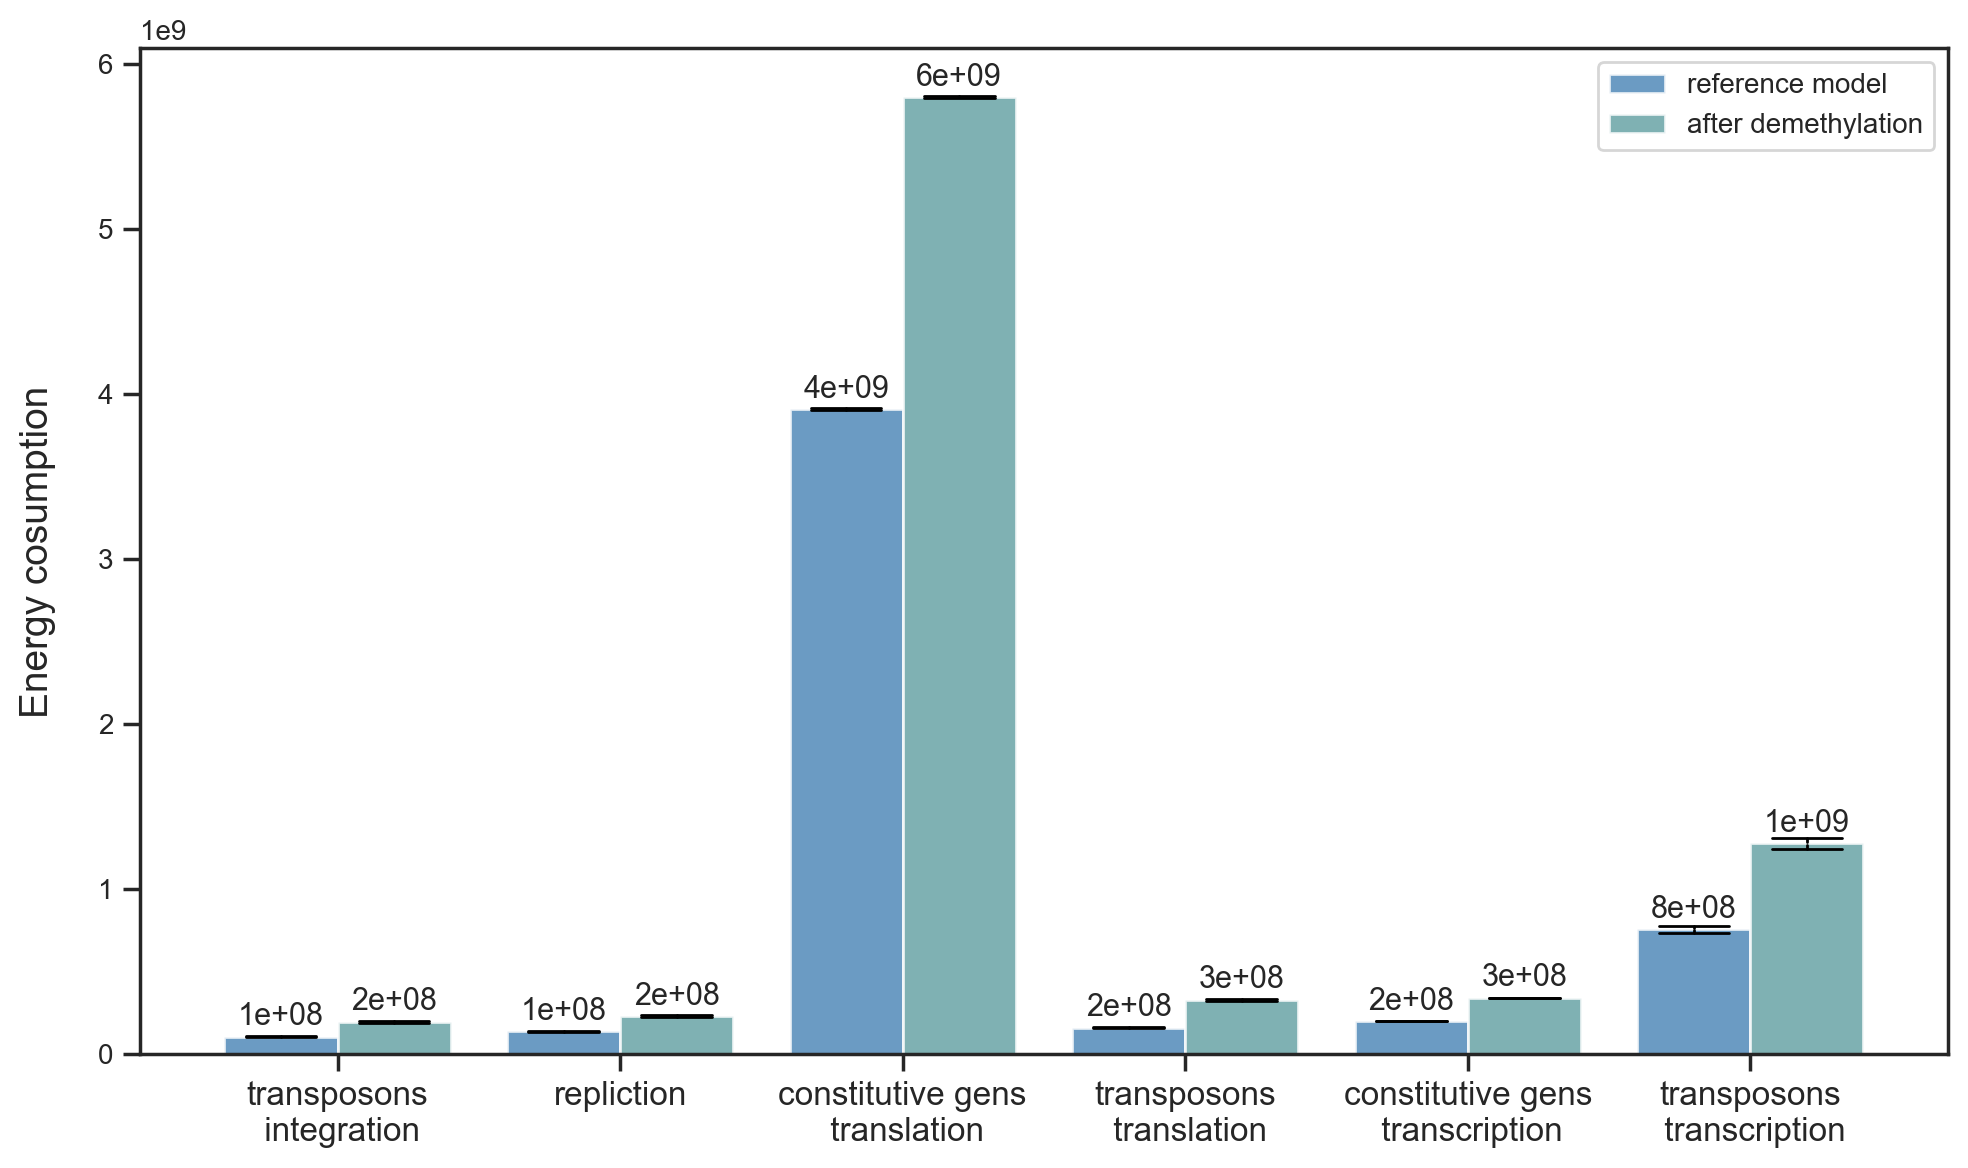

In [15]:
# Plot bar chart of energy consumption by rates:
x_ticks = ('transposons\n integration', 'repliction', 'constitutive gens\n translation', 'transposons\n translation', 
           'constitutive gens\n transcription', 'transposons\n transcription')
bar_len = np.arange(len(x_ticks))
colors = ['peachpuff', 'orange', 'tomato','peachpuff', 'orange', 'tomato']

# set figure
fig, ax = plt.subplots(figsize=(10,6))

# Rates of energy consumption::
ecr  = en_cons_rates(y0)
ecr2 = en_cons_rates(y2)

# plot bars
bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, label='reference model', color='steelblue')
bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, label='after demethylation', color='cadetblue')

# Plot errors
bplot = ax.boxplot(en_cons[:,:],
                   positions=np.array([*range(6)])-0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

bplot = ax.boxplot(en_cons2[:,:],
                   positions=np.array([*range(6)])+0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Set axes
ax.bar_label(bar, fmt='%.0e', fontsize=11, padding=2)
ax.bar_label(bar2, fmt='%.0e', fontsize=11, padding=2)
ax.set_xticks(bar_len, x_ticks, fontsize=12, rotation=0)
ax.set_ylabel('Energy cosumption', labelpad=15, rotation=90)
# ax.set_yscale('log')
ax.legend() 
plt.tight_layout()

# save figure
fig_name = "en_cons_compare_models"
plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
plt.savefig(dir_pic+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

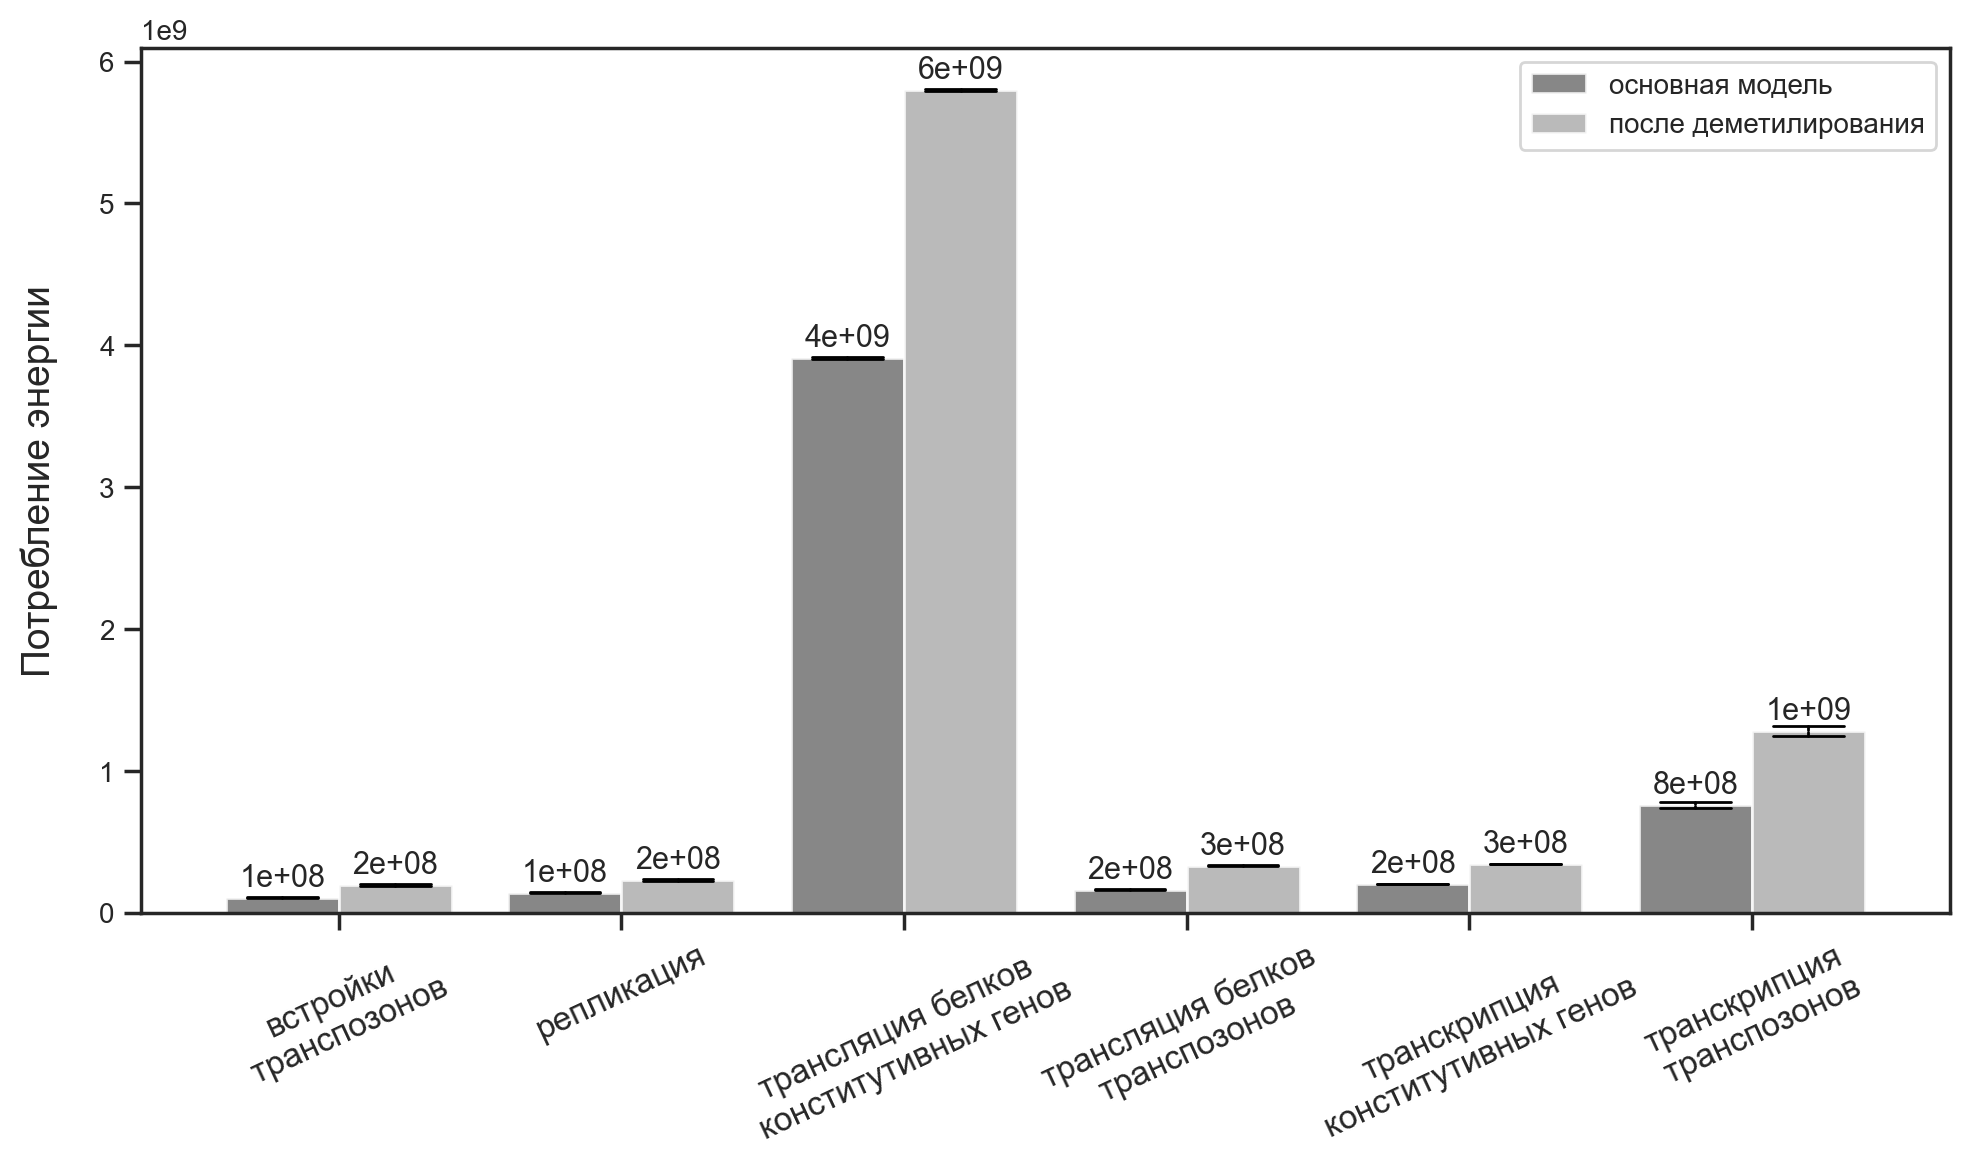

In [16]:
# Plot bar chart of energy consumption by rates:
x_ticks = ('встройки\n транспозонов', 'репликация', 'трансляция белков\n конститутивных генов', 'трансляция белков\n транспозонов', 
           'транскрипция\n конститутивных генов', 'транскрипция\n транспозонов')
bar_len = np.arange(len(x_ticks))
colors = ['peachpuff', 'orange', 'tomato','peachpuff', 'orange', 'tomato']

# set figure
fig, ax = plt.subplots(figsize=(10,6))

# Rates of energy consumption::
ecr = en_cons_rates(y0)
ecr2 = en_cons_rates(y2)

# plot bars
bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, label='основная модель', color='dimgrey')
bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, label='после деметилирования', color='darkgrey')

# Plot errors
bplot = ax.boxplot(en_cons[:,:],
                   positions=np.array([*range(6)])-0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

bplot = ax.boxplot(en_cons2[:,:],
                   positions=np.array([*range(6)])+0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Set axes
ax.bar_label(bar, fmt='%.0e', fontsize=11, padding=2)
ax.bar_label(bar2, fmt='%.0e', fontsize=11, padding=2)
ax.set_xticks(bar_len, x_ticks, fontsize=12, rotation=25)
ax.set_ylabel('Потребление энергии', labelpad=15, rotation=90)
# ax.set_yscale('log')
ax.legend() 
plt.tight_layout()

# save figure
fig_name = "en_cons_compare_models_bw"
plt.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
plt.savefig(dir_pic+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()